# Reading and Understanding the Data 

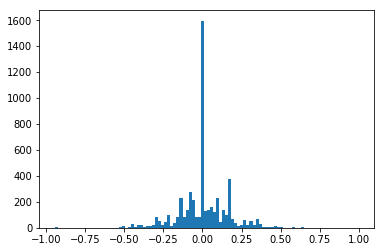

In [1]:
import numpy as np
import pandas as pd
from pandas.io.parsers import read_csv
import csv
import random
import os
import matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
import math
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

img_list = list()

data_dir = 'IMG'
path = '/CarND-Behavioral-Cloning-P3/'
data_csv = '~/CarND-Behavioral-Cloning-P3/driving_log.csv'

df = pd.read_csv(data_csv, header=None,
                names =['center','left', 'right', 'steering','throttle', 'brake'], index_col = False)

steering = np.array(df.steering, dtype=np.float32)

with open('driving_log.csv', 'r') as csvfile:
    reader = csv.reader(csvfile)
    next(reader)
    for row in reader:
        center = row[0].strip()
        left = row[1].strip()
        right = row[2].strip()
        steering = np.array(row[3], dtype=np.float32)
        throttle = np.array(row[4], dtype=np.float32)
        
        if steering == 0:
            if (np.random.rand() <= .35):
                img_list.append([center, left, right, steering, throttle])
        else:
            img_list.append([center, left, right, steering, throttle])

histo = [x[3] for x in img_list]

bins = 100
plt.hist(histo, bins=bins)
plt.show()

In the above cell I loaded the data and created a list that captures only 35% of the zero steering angle inputs. The data loaded into the model is the Udacity data that was provided. I chose 35% because I figured that would be enough to capture the zero steering angle for the model and while not overfitting it.

# Data Processing

In [2]:
def read_img_file(image):
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    #image = image/255.-.5
    return image

def brightness_image(image):
    image_hsv = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    rnd_bright = 0.25+np.random.uniform()
    image_hsv[:,:,2] = image_hsv[:,:,2]*rnd_bright
    image_RGB = cv2.cvtColor(image_hsv, cv2.COLOR_HSV2RGB)
    return image_RGB

def img_size(image): 
    output_col = 128
    output_row = 60
    top_offset=.375 
    bottom_offset=.125
    top = int(top_offset * image.shape[0])
    bottom = int(bottom_offset * image.shape[0])
    image = cv2.resize(image[top:-bottom, :], (output_col, output_row),interpolation=cv2.INTER_AREA)
    return image

def flip_image(image, steering):
    if random.randint(0, 1):
        return cv2.flip(image, 1), -steering
    else:
        return image, steering
    
def shift_image(image, steering,shift_range):
    rows = image.shape[0]
    cols = image.shape[1]
    shift_x = shift_range*np.random.uniform()-shift_range/2
    steer_shift = steering + shift_x/shift_range*2*.2
    shift_y = 10*np.random.uniform()-10/2
    shift_dim = np.float32([[1,0,shift_x],[0,1,shift_y]])
    shift_img = cv2.warpAffine(image, shift_dim, (cols, rows))
    return shift_img, steer_shift 

The cell above contains all the image modifications used in the model for training, beginning with converting from BGR to RGB, brightness modification, size modification, image shifting and finishing with randomly flipping the resulting image.

In [4]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

#Shuffle img_list
img_list = shuffle(img_list)

#Split test img set
train_set, valid_set = train_test_split(img_list, test_size=0.3, random_state=0)

print("Train set =", len(train_set))
print("Validation set =", len(valid_set))
#print(train_set)

Train set = 3626
Validation set = 1554


The cell above shuffles image list into a testing and validation set that model uses to train and test itself.

# Generator

In [5]:
def load_data(input_data, indices):
    steer_aug = 0.1
    X = list()
    y = list()
    
    for i in indices:
        rnd = np.random.randint(0, 3)
        name = input_data[i][rnd][4:]
        image = cv2.imread(os.path.join(data_dir,name))
        y_steer = input_data[i][3]
        
        if rnd ==1:
            y_steer += steer_aug
        elif rnd ==2:
            y_steer -= steer_aug
            
        X.append(image)
        y.append(y_steer)
        
    return X, y

In [6]:
def generator(samples, batch, augment= True):
    while True:
        X_batch = []
        y_batch = []
        
        indicies = np.random.randint(0, len(samples), batch)
        
        X, y = load_data(samples, indicies)
        
        for i in range(batch):
            image = X[i]
            y_steer = y[i]
            image = read_img_file(image)
            image,y_steer = shift_image(image,y_steer,150)
            image = brightness_image(image)
            image,y_steer = flip_image(image, y_steer)
            image = img_size(image)

            X_batch.append(image)
            y_batch.append(y_steer)
            
        yield np.array(X_batch), np.array(y_batch)   

The cell above shows the generator that is used in the Keras model below. The generator leverages the image modification processes described above and includes modification to the steering angles for both left and right camera angles. The generator yield an array of images and steering values that are then fed into the model.

In [7]:
import tensorflow as tf
from keras import models, optimizers, backend
from keras.layers import Dense, Convolution2D, MaxPooling2D, Activation, Dropout, Flatten, Lambda
from keras.optimizers import Adam

img_row = 60
img_col = 128
img_ch = 3


model = models.Sequential()
model.add(Lambda(lambda x: x/127.5 - .5, input_shape=(img_row, img_col, img_ch),output_shape=(img_row, img_col, img_ch)))
model.add(Convolution2D(24, 5, 5, border_mode='same', input_shape=(img_row, img_col, img_ch), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
model.add(Convolution2D(36, 5, 5, border_mode='same', activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
model.add(Convolution2D(48, 5, 5, border_mode='same', activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(200, activation='relu'))
model.add(Dropout(.2))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))

adam = Adam(lr=1e-04)
model.compile(optimizer=adam, loss='mse')

          
print(model.summary())

Using TensorFlow backend.


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 60, 128, 3)    0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 60, 128, 24)   1824        lambda_1[0][0]                   
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 30, 64, 24)    0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 30, 64, 36)    21636       maxpooling2d_1[0][0]             
___________________________________________________________________________________________

The model architecture above is based off the Nvidia paper that describes end to end learning for self driving cars. The network consists of 9 layers, including a normalization layer, 5 convolutional layers, and 3 fully connected layers. The model had 3,818,069 trainable parameters. 

The first layer of the network performs image normalization using the lambda function and the desired output shape. The rest of the model flows as follows:

1. Lambda Normalization (60, 128, 3)
2. Convolution - First Layer (60, 128, 24)
3. Max Pooling - First Layer (30, 64, 24)
4. Convolution - Second Layer (30, 64, 36)
5. Max Pooling - Second Layer (15, 32, 36)
6. Convolution - Third Layer (15, 32, 48)
7. Max Pooling - Third Layer (7, 16, 48)
8. Convolution - Fourth Layer (7, 16, 64)
9. Convolution - Fifth Layer (7, 16, 64)
10. Flatten - (7168)
11. Fully Connected - Sixth Layer (500)
12. Dropout - (500)
13. Fully Connected - Seventh Layer (200)
14. Dropout - (200)
15. Fully Connected - Eight Layer (10)
16. Output - (1) 

Using the ADAM optimizer with a learning rate of 1e-4. Futher, because this is a continous regression problem we are using mean squared error as the loss function

In [8]:
from pathlib import Path
import json

def save_model(model_json, h5):
    json_string = model.to_json()
    with open(model_json, 'w' ) as f:
        json.dump(json_string, f)
    model.save(h5)
               
    print('Model Saved')

In [10]:
sm_limit = 1 
batch = 50
sample_epoch_train= 20000
sample_epoch_valid= 2000
n_epoch = 1

i_best = 0 
val_best = 1000

for i in range(10): 
    history = model.fit_generator(generator(train_set, batch), verbose =1,
                              samples_per_epoch=sample_epoch_train,
                              nb_epoch=n_epoch, 
                              validation_data=generator(valid_set, batch),
                              nb_val_samples=sample_epoch_valid)
    
    model_json = 'model_' + str(i) + '.json'
    h5 = 'model_' + str(i) + '.h5'
    save_model(model_json,h5)
    
    val_loss = history.history['val_loss'][0]
    if val_loss < val_best:
        i_best = i
        val_best = val_loss
        model_json = 'model_best.json'
        weights = 'model_best.h5'
        save_model(model_json,weights)
        
    sm_limit = 1/(i+1)
    
#print('Best model found at iteration # ' + str(i_best))
#print('Best Validation score : ' + str(np.round(val_best,4)))

Epoch 1/1
20000/20000 [==============================] - 68s - loss: 0.0749 - val_loss: 0.0322

The model runs 10 times with 1 epoch each time using 20,000 images of training data. The model is then compared to 2,000 images from the validation set in order to gauge the effectiveness of the model. The code above also contains a check where it compares the validation loss of the most recent to previous model in order to judge which is best. The best model is then saved as a .h5 file and a .json file. 